# Analyze DBTL1 recommendations
Analyze the recommendations for DBTL1. 

`art_modeling_and_recommend_DBTL1` produced a dataframe consisting of every combination of 5 gRNAs, along with ART-predicted mean and std predictions for titer. Here, I'll filter and sort the recommendations based on a few criteria:
- changing exploration vs exploitation - Different recommendations will look better or worse based on whether we want to priorities exploration or exploitation
- Different requested numbers of 2-, 3-, 4-, and 5-gRNA recommendations - Experimental collaborators may want different numbers of each.
- Different levels of variety in gRNA - It's possible that ART identified two gRNAs (A and B, for instance) that it considers optimal, and every high-ranking recommendation for 3-gRNA strains will look like A + B + X. In this case, we may want to filter out some of these recommendations.

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../art/'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
fig_loc = './dbtl1_figures_and_analysis/'

## 1 Import `rec_df`, `data_df`, and trained ART model.

Import recommendation dataframe

In [4]:
rec_df = pd.read_pickle('./dbtl1_figures_and_analysis/DBTL1_rec_df.pkl')

In [5]:
rec_df.head(3)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.810007,54.424123
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148.572879,54.479797
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.557312,54.471682


Get the columns related to gRNA (perturbations) from the recs.

In [6]:
pert_columns = rec_df.columns[:-2]

Dataframe of training data

In [7]:
data_df = pd.read_pickle(f'./dbtl1_figures_and_analysis/dbtl0_dbtl1_isoprenol_processed_df.pkl')

In [8]:
data_df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,1,Control-R1
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,2,Control-R2
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,3,Control-R3


trained ART model:

In [9]:
art_path = './dbtl1_art_outputs/art.cpkl'
with open(art_path, 'rb') as art_file:
    art = cloudpickle.load(art_file)

### 1.1 Add information to `rec_df`
Since we generated recs for all possible combinations of gRNA, some of the recs are in the experimental data. It would be useful to check if recommendations are in the experimental data or not.

First, add a `number_of_grna` column to recommendations to make them easier to filter.

In [10]:
rec_df['number_of_grna'] = rec_df.loc[:, pert_columns].apply(sum, axis = 1).astype(int)

Add indicator column to `rec_df`

In [11]:
rec_df['in_expt'] = 0

Iterate through rows of experimental data (since there is less of it)

In [12]:
for idx, expt_row in data_df.iterrows():
    n_grna_expt = expt_row['number_of_grna']
    rec_df_subset = rec_df[rec_df['number_of_grna']==n_grna_expt]
    
    matching_subset_index = np.where(np.all(rec_df_subset.loc[:, pert_columns] == expt_row[pert_columns], axis = 1))
    assert len(matching_subset_index)==1, 'ERROR: experimental data missing from recommendations'
    rec_df_index = rec_df_subset.iloc[matching_subset_index[0],:].index
    rec_df.loc[rec_df_index, 'in_expt'] = int(1)

In [13]:
rec_df[rec_df['in_expt'] == 1]['number_of_grna'].value_counts()

number_of_grna
1    57
3    30
2    27
0     1
Name: count, dtype: int64

In [14]:
data_df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,1,Control-R1
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,2,Control-R2
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,3,Control-R3
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,4,Control-R4
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,5,Control-R5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,PP_0437_PP_3365-R3,DBTL1_P4_044,mg/L,247.03410,3,PP_0437_PP_3365,None,1,False,"[PP_0437, PP_3365]",...,0,0,0,0,0,0,True,1,3,PP_0437_PP_3365-R3
593,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,mg/L,208.59250,3,PP_1319_PP_4121_PP_4667,None,1,False,"[PP_1319, PP_4121, PP_4667]",...,0,0,0,0,0,0,True,1,3,PP_1319_PP_4121_PP_4667-R3
594,PP_0814_PP_4192-R3,DBTL1_P4_046,mg/L,328.09770,3,PP_0814_PP_4192,None,1,False,"[PP_0814, PP_4192]",...,0,0,0,0,0,0,True,1,3,PP_0814_PP_4192-R3
595,PP_0812_PP_4121-R3,DBTL1_P4_047,mg/L,294.92530,3,PP_0812_PP_4121,None,1,False,"[PP_0812, PP_4121]",...,0,0,0,0,0,0,True,1,3,PP_0812_PP_4121-R3


In [15]:
data_df[data_df['has_cycle1_gene']]['number_of_grna'].value_counts()

number_of_grna
1    192
3     90
2     90
Name: count, dtype: int64

## 2. Characterize All Recommendations
Here we will look at the range of outcomes in all the candidate recommendations.

### 2.1 Plot distributions of mean and std
Here we will visualize how the recommendations compare to the training data distribution.

Compare predicted titer for all recommendations against the titer of the training data

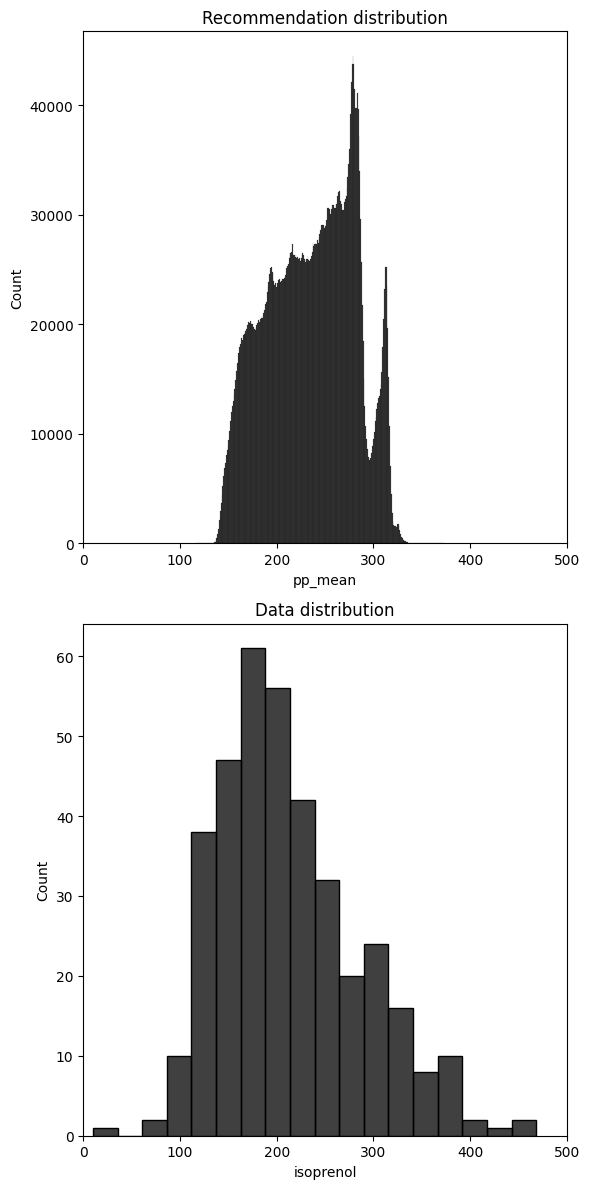

In [16]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,12))
sns.histplot(data = rec_df, x = 'pp_mean', color = 'k', ax = ax[0])
sns.histplot(data = data_df[data_df['has_cycle1_gene']], x = 'isoprenol', color = 'k', ax = ax[1])
ax[0].set_title('Recommendation distribution')
ax[0].set_xlim([0, 500])
ax[1].set_title('Data distribution')
ax[1].set_xlim([0, 500])
fig.tight_layout()
fig.savefig(fig_loc + 'compare_rec_and_data_distribution_filled_hist.png')

Same as above, but with overlayed histograms.

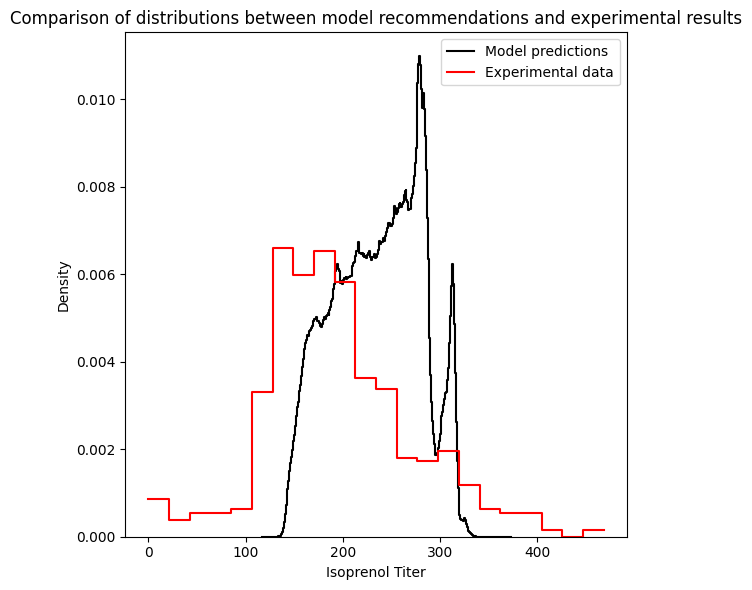

In [17]:
fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(data=rec_df, x="pp_mean", ax = ax, color = 'k', fill=False, element = 'step', stat = 'density')
sns.histplot(data = data_df, x = 'isoprenol', ax = ax, color = 'r', fill = False, element = 'step', stat = 'density')
ax.set_xlabel('Isoprenol Titer')
plt.legend(['Model predictions', 'Experimental data'])
plt.title('Comparison of distributions between model recommendations and experimental results')
fig.tight_layout()
fig.savefig(fig_loc + 'compare_rec_and_data_distribution_step_hist.png')

Plot the distribution of mean and std for recommendations.

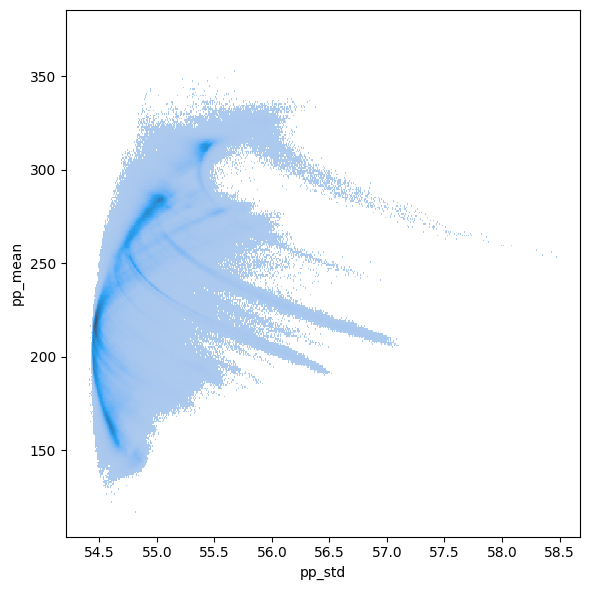

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(data = rec_df, x = 'pp_std', y = 'pp_mean')
fig.tight_layout()
fig.savefig(fig_loc + 'recommendation_joint_mean_std_histogram.png')

Plot the distribution of mean and std as individual distributions. 

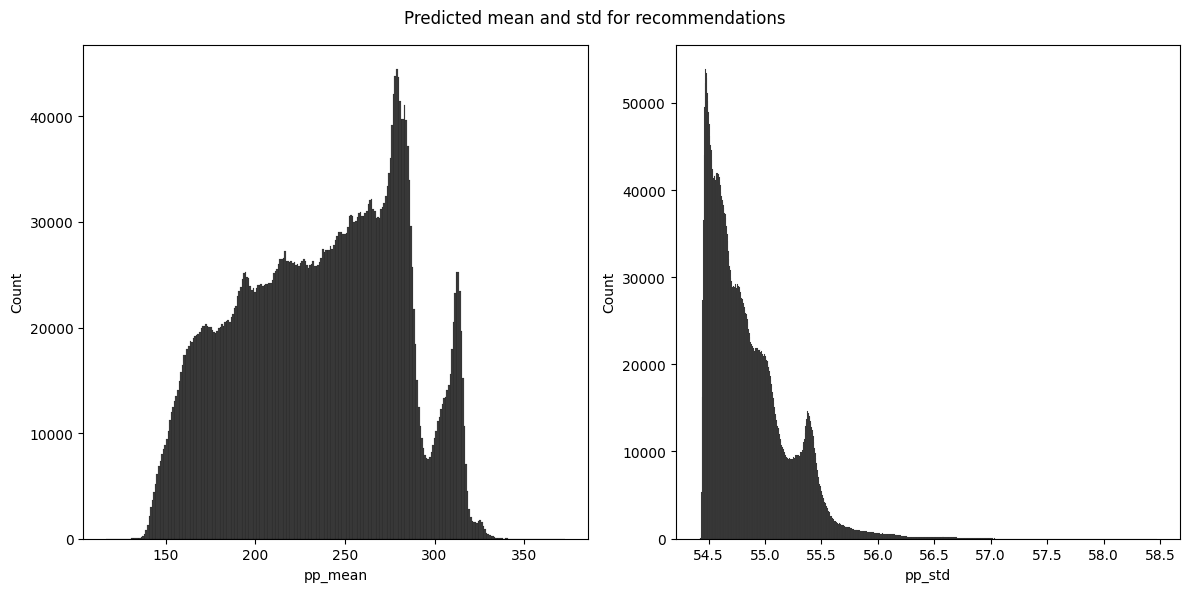

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.histplot(data = rec_df, x = 'pp_mean', color = 'k', ax = ax[0])
sns.histplot(data = rec_df, x = 'pp_std', color = 'k', ax = ax[1])
plt.suptitle('Predicted mean and std for recommendations')
fig.tight_layout()
fig.savefig(fig_loc + 'recommendation_dist_mean_and_std.png')

Plot the distribution of recs with high titer

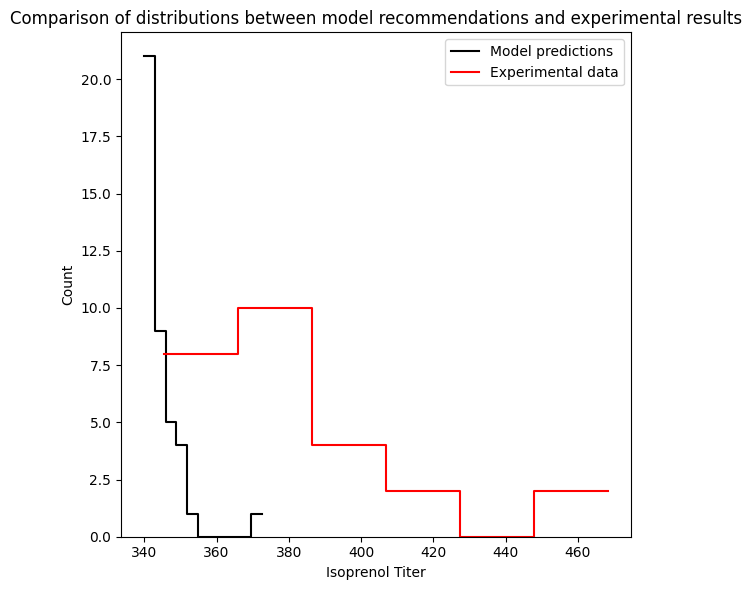

In [20]:
titer_threshold = 340

fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(data=rec_df[rec_df['pp_mean']>titer_threshold], x="pp_mean", ax = ax, color = 'k', fill=False, element = 'step', stat = 'count')
sns.histplot(data = data_df[data_df['isoprenol']>titer_threshold], x = 'isoprenol', ax = ax, color = 'r', fill = False, element = 'step', stat = 'count')
ax.set_xlabel('Isoprenol Titer')
plt.legend(['Model predictions', 'Experimental data'])
plt.title('Comparison of distributions between model recommendations and experimental results')
fig.tight_layout()
fig.savefig(fig_loc + 'compare_rec_and_data_distribution_step_hist_hightiter.png')

### 2.2 Break distributions down by number of gRNA

Distributions of mean and std split up by number of gRNA

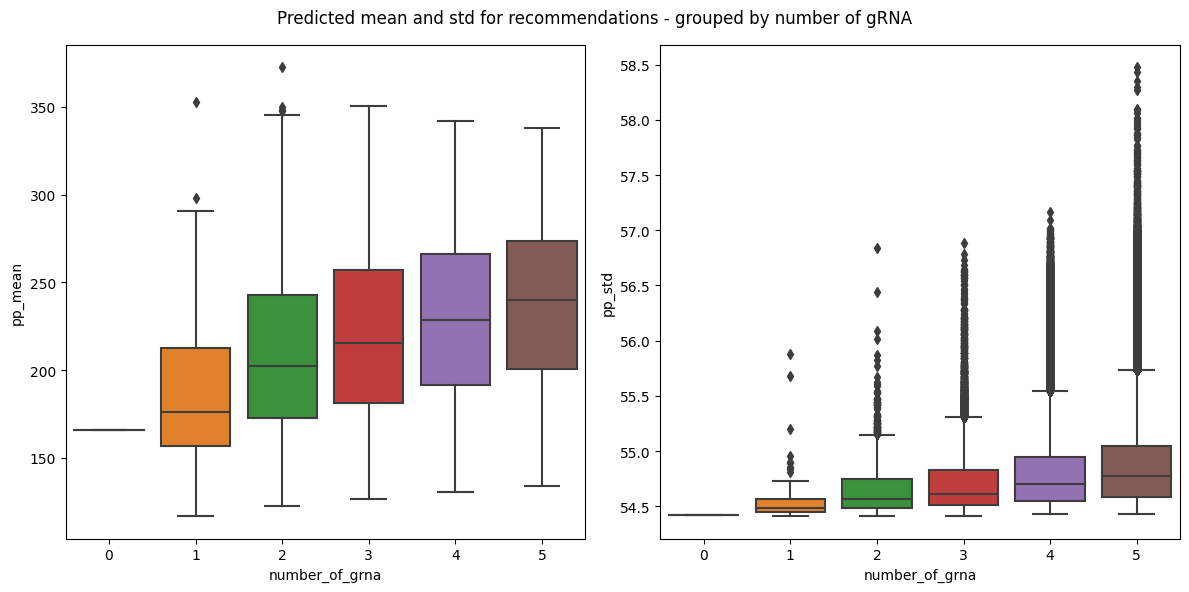

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.boxplot(data = rec_df, y = 'pp_mean', x = 'number_of_grna', ax = ax[0])
sns.boxplot(data = rec_df, y = 'pp_std', x = 'number_of_grna', ax = ax[1])
plt.suptitle('Predicted mean and std for recommendations - grouped by number of gRNA')
fig.tight_layout()
fig.savefig(fig_loc + 'recommendation_dist_mean_and_std_gRNA_num_grouping.png')

### 2.3 Break distributions down by number of gRNA

Distributions of mean and std split up by number of gRNA

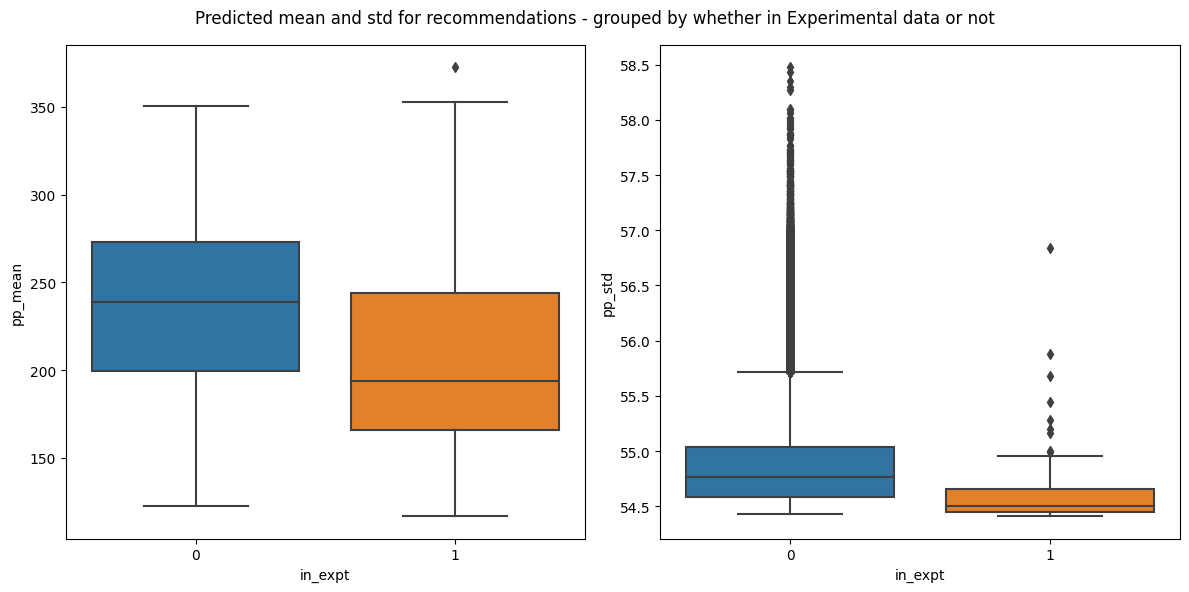

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.boxplot(data = rec_df, y = 'pp_mean', x = 'in_expt', ax = ax[0])
sns.boxplot(data = rec_df, y = 'pp_std', x = 'in_expt', ax = ax[1])
plt.suptitle('Predicted mean and std for recommendations - grouped by whether in Experimental data or not')
fig.tight_layout()
fig.savefig(fig_loc + 'recommendation_dist_mean_and_std_expt_grouping.png')

## 3. Analyze best recommendations

### 3.1 Plot draw distribution for top recs
After training, ART enables us to visualize the entire predicted probability distribution for any input. Here, we use that capability to visualize the distribution of the candidate recs with the highest titer.

Get a subset of `rec_df` to work with

In [23]:
expt_recs = rec_df[rec_df['in_expt'] == 1]
rec_df_high = rec_df[(rec_df['in_expt'] == 0) & (rec_df['pp_mean']>300)]

Get top 10 predictions by predicted titer.

In [24]:
top_preds = rec_df_high.sort_values(by = 'pp_mean', ascending = False).iloc[:10,:]

Add 

Define function to write a human-readable line name for a given recommendation and add it to the dataframe.

In [25]:
write_line_name = lambda x: '_'.join(pert_columns[np.where(x == 1)])
top_preds['line_name'] = top_preds.loc[:, pert_columns].apply(write_line_name, axis = 1)
top_preds

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,line_name
15901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,350.671418,55.681415,3,0,PP_0815_PP_1317_PP_4862
15903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,349.657907,55.589638,3,0,PP_0815_PP_1317_PP_5288
15869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,349.270506,55.527478,3,0,PP_0815_PP_1317_PP_1769
15899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,348.458802,55.492101,3,0,PP_0815_PP_1317_PP_4678
228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,348.457446,55.224632,2,0,PP_0528_PP_0813
264,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,347.660746,55.441726,2,0,PP_0528_PP_4191
6456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,347.548418,55.312001,3,0,PP_0528_PP_0815_PP_1317
15893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,346.305411,55.416897,3,0,PP_0815_PP_1317_PP_4192
241,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,345.376775,55.066077,2,0,PP_0528_PP_1769
15885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,345.326270,55.365165,3,0,PP_0815_PP_1317_PP_4120


Define color palette for distribution plots.

In [26]:
pal = sns.cubehelix_palette(10, rot=-0.45, start=0.0, dark=0.3, light=0.7, reverse=True)

Define function to get draws and plot them using trained ART model. 

In [27]:
def plot_draws(preds, feature_columns, prev_max = None, title_text = None):
    fig, ax = plt.subplots(figsize = (6,6))
    draws = art.post_pred_draws(preds.loc[:,feature_columns], n_samples = 1000)[0]
    draws_df = pd.DataFrame(data = draws, columns = preds['line_name'])
    draws_df = pd.melt(draws_df, value_vars= preds['line_name'], value_name = 'titer', var_name = 'Line Name')

    pal = sns.cubehelix_palette(10, rot=-0.45, start=0.0, dark=0.3, light=0.7, reverse=True)
    sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, split = True, ax = ax)
    if prev_max is not None:
        ax.axvline(prev_max, color = 'k', linestyle = '--', linewidth = 0.5)
    if title_text is not None:
        ax.set_title(title_text)
        
    return fig

Use function to plot top 10 candidate recommendations.

Sampling: [y]


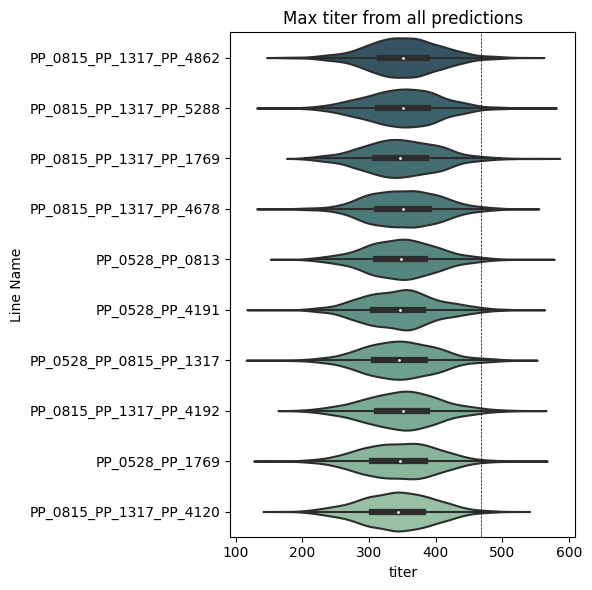

In [28]:
fig = plot_draws(top_preds, pert_columns, prev_max = data_df['isoprenol'].max(), title_text = 'Max titer from all predictions')
fig.tight_layout()
fig.savefig(f'./dbtl1_figures_and_analysis/predictions_max_titer_from_all_preds.png')

### 3.2 Plot top recs for each number of gRNA

Iterate through possible numbers of guide RNA to recommend and plot distributions.

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


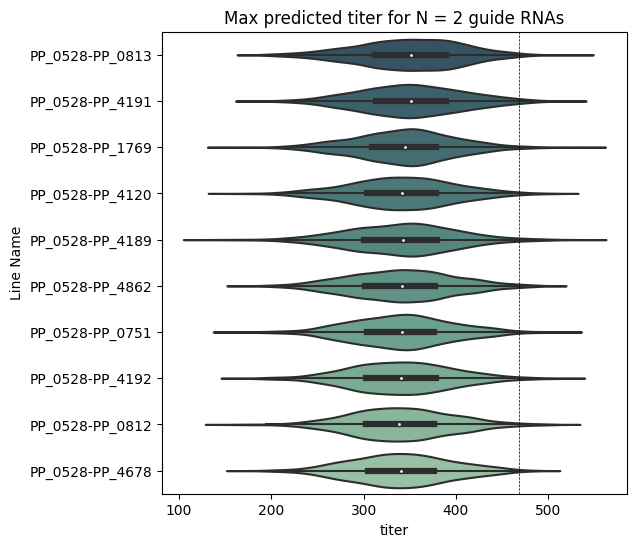

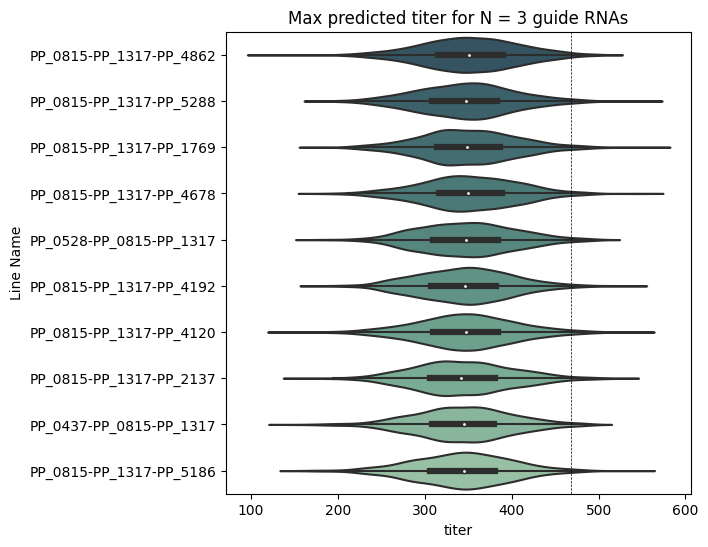

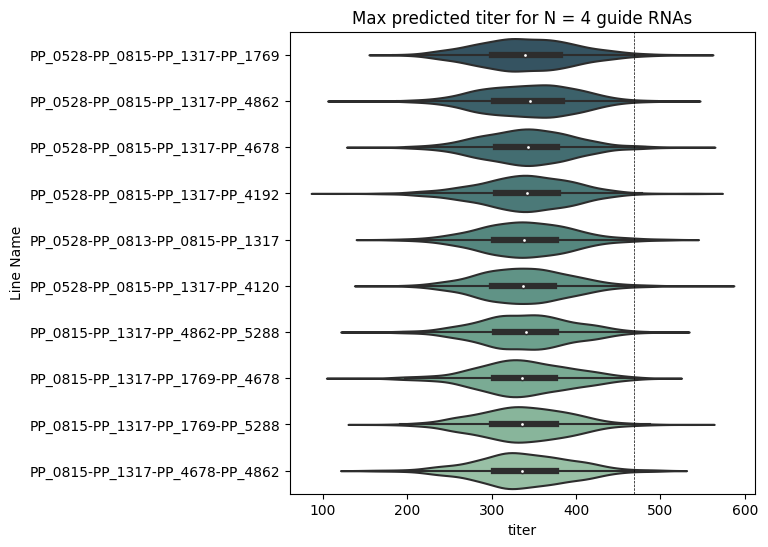

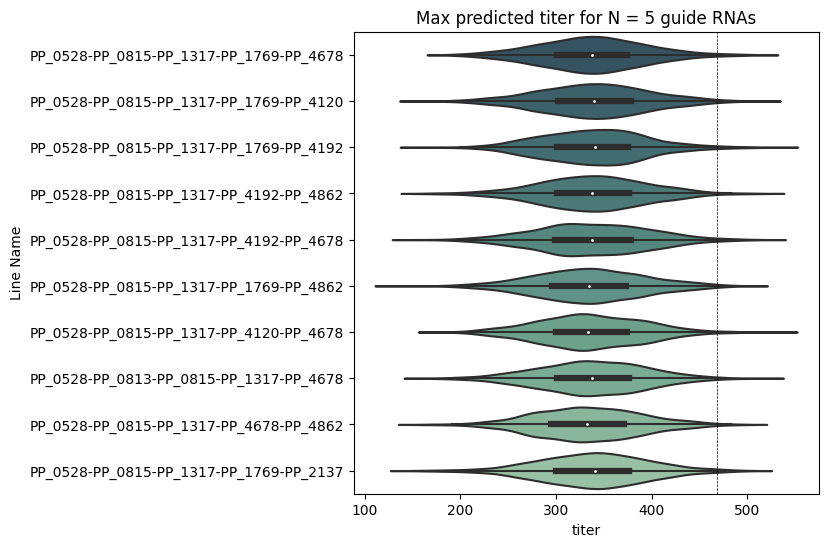

In [29]:
possible_grna_number = [2,3,4,5]
for ii, n_grna in enumerate(possible_grna_number):
    candidate_idx = (rec_df_high['number_of_grna'] == n_grna)
    top_preds = rec_df_high[candidate_idx].sort_values(by = 'pp_mean', ascending = False).iloc[:10,:]
    top_preds['line_name'] = top_preds.loc[:, pert_columns].apply(write_line_name, axis = 1)
    top_preds['line_name'] = top_preds['line_name'].apply(lambda x: x.replace('_PP', '-PP'))
    title_text = f"Max predicted titer for N = {n_grna} guide RNAs"
    
    fig = plot_draws(top_preds, pert_columns, prev_max = data_df['isoprenol'].max(), title_text = title_text)
    fig.savefig(f'./dbtl1_figures_and_analysis/predictions_max_titer_with_{n_grna}_gRNA_.png')

### 3.3 Identify most common gRNA
Quantify how much redundancy is present in the best recommendations.

Make dataframe counting how many times each guide RNA appears in the top N recommendations sorted by titer.

In [30]:
n_recs_to_keep = 10000
top_n_recs = rec_df_high.sort_values(by = 'pp_mean', ascending = False).iloc[:n_recs_to_keep,:]
grna_count = np.sum(top_n_recs.loc[:, pert_columns], axis = 0)
grna_count_df = pd.DataFrame(data = grna_count)
grna_count_df = grna_count_df.reset_index()
grna_count_df=grna_count_df.rename(columns={grna_count_df.columns.values[1]:'counts', 'index':'grna'})


Plot and format the counts datafame

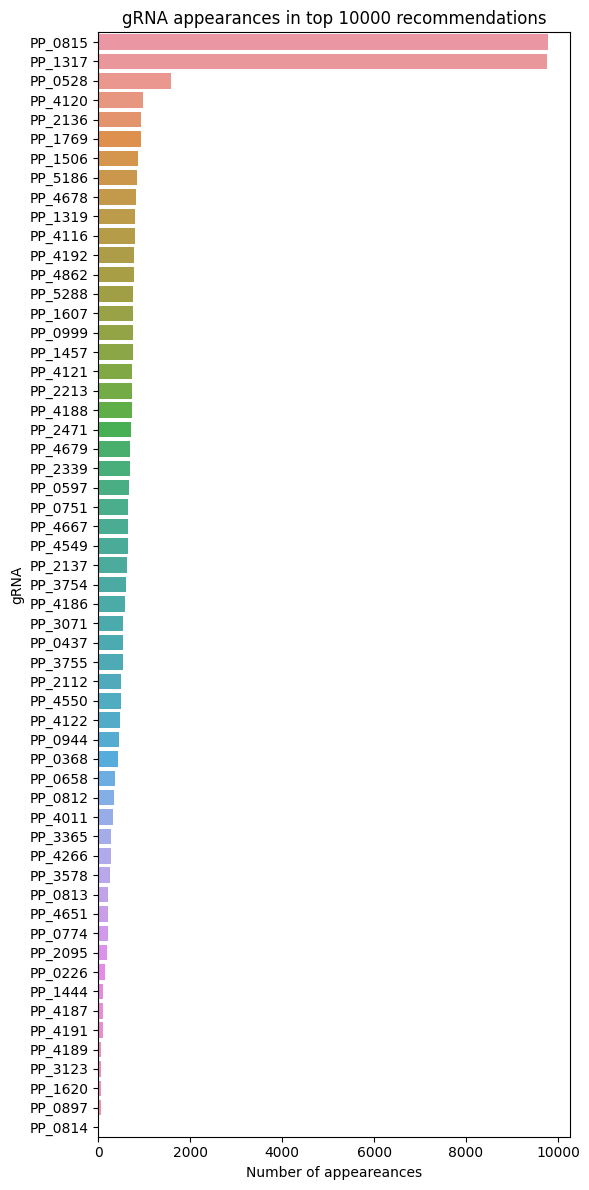

In [31]:
fig, ax = plt.subplots(figsize = (6,12))
sns.barplot(grna_count_df.sort_values(by = 'counts', ascending = False), x = 'counts', y = 'grna', ax = ax)
ax.set_title(f'gRNA appearances in top {n_recs_to_keep} recommendations')
ax.set_xlabel('Number of appeareances')
ax.set_ylabel('gRNA')
fig.tight_layout()
fig.savefig(f'{fig_loc}gRNA_appearances_in_topN_recs.png')

## 4.Vary $\alpha$ and examine recs
The parameter $\alpha$ controls how much ART recommendations account for the predicted mean and the predicted uncertainty (std. dev.). The formula used in art is

$obj = (1-\alpha) * [mean] + \alpha * [std dev]$

Using $\alpha$ = 0 yields recommendations based entirely on maximizing the predicted mean (exploitation), while $\alpha$ = 1 yields recommendations based on identifying regions of input space that are most uncertain (exploration).

Define alpha value and create an objective value in rec_df

In [32]:
ALPHA = 0.8
rec_df['obj'] = rec_df['pp_mean'] * (1-ALPHA) + rec_df['pp_std'] * ALPHA

Create a cutoff for the objective value and create a smaller dataset.

In [33]:
obj_cutoff = np.percentile(rec_df['obj'], 90)
rec_df_high_obj = rec_df[(rec_df['in_expt']==0) & (rec_df['obj']>obj_cutoff)]

Get the top 10 predictions sorted by objective value

In [34]:
top_preds_obj = rec_df_high_obj.sort_values(by = 'obj', ascending = False).iloc[:10,:]
top_preds_obj

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,obj
15901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,350.671418,55.681415,3,0,114.679416
15903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,349.657907,55.589638,3,0,114.403292
15869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,349.270506,55.527478,3,0,114.276084
15899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,348.458802,55.492101,3,0,114.085441
264,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,347.660746,55.441726,2,0,113.885530
228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,348.457446,55.224632,2,0,113.871195
6456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,347.548418,55.312001,3,0,113.759285
15893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,346.305411,55.416897,3,0,113.594600
15885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,345.326270,55.365165,3,0,113.357386
15873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,344.795562,55.459841,3,0,113.326985


Add human-readable line name to the dataframe

In [35]:
top_preds_obj['line_name'] = top_preds_obj.loc[:, pert_columns].apply(write_line_name, axis = 1)

Plot the distribution of the top recommendations by objective

Sampling: [y]


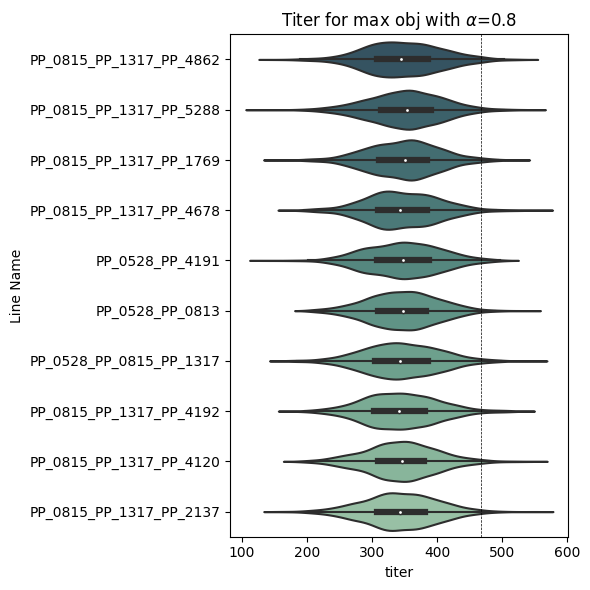

In [36]:
fig = plot_draws(top_preds_obj, pert_columns, prev_max = data_df['isoprenol'].max(), title_text = f'Titer for max obj with $\\alpha$={ALPHA}')
fig.tight_layout()
fig.savefig(f'./dbtl1_figures_and_analysis/predictions_max_titer_from_all_preds_alpha{ALPHA}.png')

Plot the most common gRNA in the recs sorted by objective value. 

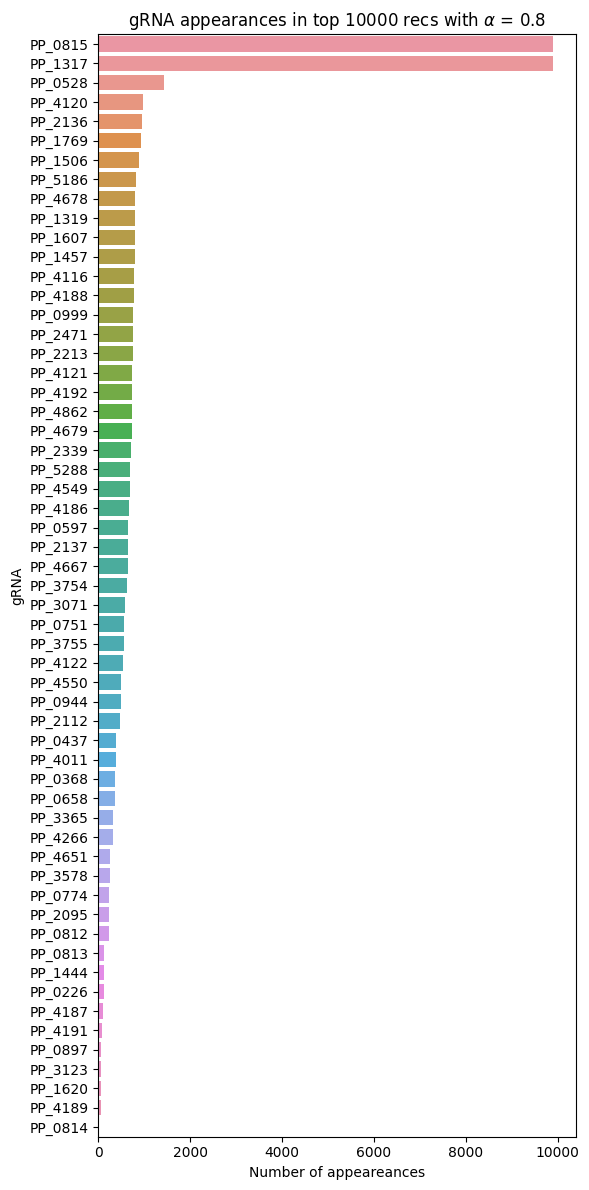

In [37]:
top_n_recs = rec_df_high_obj.sort_values(by = 'obj', ascending = False).iloc[:n_recs_to_keep,:]
grna_count = np.sum(top_n_recs.loc[:, pert_columns], axis = 0)
grna_count_df = pd.DataFrame(data = grna_count)
grna_count_df = grna_count_df.reset_index()
grna_count_df=grna_count_df.rename(columns={grna_count_df.columns.values[1]:'counts', 'index':'grna'})

grna_count_df
fig, ax = plt.subplots(figsize = (6,12))
sns.barplot(grna_count_df.sort_values(by = 'counts', ascending = False), x = 'counts', y = 'grna', ax = ax)
ax.set_title(f'gRNA appearances in top {n_recs_to_keep} recs with $\\alpha$ = {ALPHA}')
ax.set_xlabel('Number of appeareances')
ax.set_ylabel('gRNA')
fig.tight_layout()
fig.savefig(f'{fig_loc}gRNA_appearances_in_topN_recs_alpha{ALPHA}.png')